In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import pandas as pd
from scipy import stats
import statsmodels.formula.api as sm
import pandas as pd

In [2]:
def get_empirical_data(chosenDomain, statistic): # statistic = cc, r, mgd
    Domain_Dict = {}
    for domain_temp in ["Social", "Biological", "Informational", "Technological"]:
        X = [] # number of nodes
        Y = [] # network statistic
        all_files = os.listdir("../Results/empirical_netstats/" + domain_temp)
        for gml_graphname in all_files:
            if statistic in ['k', 'cc', 'r']:
                pickle_in = open("../Results/empirical_netstats/" + domain_temp + "/" + gml_graphname[:-4] + ".pkl", "rb")
                Results = pickle.load(pickle_in)
                pickle_in.close()
                
                if statistic == "k":
                    k = 2 * Results[2] / Results[1] # 2m/n
                    Y.append(k)
                elif statistic == "cc":
                    cc = Results[3]
                    Y.append(cc)
                else:
                    r = Results[4] 
                    Y.append(r)
                    
            elif statistic == 'mgd':
                pickle_in = open("../Results/real_MGD/" + domain_temp + "/" + gml_graphname[:-4] + ".pkl", "rb")
                Results = pickle.load(pickle_in)
                pickle_in.close()
                mgd = Results[3]
                Y.append(mgd)
                
            X.append(Results[1])
            
        Domain_Dict[domain_temp] = (X, Y)
        
    return Domain_Dict

In [3]:
def scatter_empirical_data(Domain_Dict, chosenDomain, statistic, xtickSize=20, ytickSize=20):
    X = Domain_Dict[chosenDomain][0]
    Y = Domain_Dict[chosenDomain][1]

    if statistic == "cc":
        X_filtered = []
        Y_filtered = []

        for i in range(len(Y)):
            if Y[i] != 0:
                X_filtered.append(X[i])
                Y_filtered.append(Y[i])
    else:
        X_filtered = X
        Y_filtered = Y

    plt.figure(figsize = (5, 5))
    plt.scatter(X_filtered, Y_filtered, c = "black", alpha = 0.15) # SCATTER EMPIRICAL VALUES
    plt.xscale('log')
        
    if statistic == "cc":
        plt.ylim(0.000006, 1.4)
        y_label = "Clustering coefficient, C"
        plt.yscale('log')
    elif statistic == "r":
        plt.ylim(-0.9, 0.79)
        y_label = "Degree assortativity, r"
    elif statistic == "mgd":
        plt.ylim(-0.5, 13)
        y_label = "Mean geodesic distance, L "
        
    plt.xlim(1, 10000000)
    plt.xlabel("Nodes, n", fontsize = 20, color = "black")
    plt.ylabel(y_label, fontsize = 20, color = "black")
    plt.xticks(fontsize = xtickSize, color = "black")
    plt.yticks(fontsize = ytickSize, color = "black")

    
    return X_filtered, Y_filtered

In [4]:
def get_null_data(chosenDomain, statistic, null):
    if statistic == "cc":
        stat_index = 3
    elif statistic == "r":
        stat_index = 4
    elif statistic == "mgd":
        stat_index = 5
        
    if null == "G_nm":
        folder = "../Results/Gnm_netstats/"
    elif null == "Configuration":
        folder = "../Results/Config_netstats/"
    elif null == "DCSBM":
        folder = "../Results/DCSBM_netstats/"
        
    domain_list = ["Social", "Technological", "Informational", "Biological"]
    Domain_Dict = {}
    for domain in domain_list:
        X = []
        Y = []
        
        AllFiles = os.listdir(folder + domain + "/")

        for gml_filename in AllFiles:
            if gml_filename != ".ipynb_checkpoints":
                pickleFile = folder + domain + "/" + gml_filename
                pickle_in = open(pickleFile,"rb")
                Results = pickle.load(pickle_in)
 
                if len(Results[stat_index]) !=0 and np.mean(Results[4]) == np.mean(Results[4]):
                    X.append(Results[1])
                    Y.append(np.mean(Results[stat_index])) 

        Domain_Dict[domain] = (X, Y)

    X = Domain_Dict[chosenDomain][0]
    Y = Domain_Dict[chosenDomain][1]
    
    if statistic == "cc":
        X_filtered = []
        Y_filtered = []

        for i in range(len(Y)):
            if Y[i] != 0:
                X_filtered.append(X[i])
                Y_filtered.append(Y[i])
    else:
        X_filtered = X
        Y_filtered = Y
        
    return X_filtered, Y_filtered

In [5]:
def plot_bestFit(X_filtered, Y_filtered, domain, statistic, type_data, legend_flag = 0, model_type = "exact"):
    X_extended = [i for i in range(5, 5000000, 10)]
    if type_data == "Empirical":
        color = "orangered"
        shape = "s"
    elif type_data == "G_nm":
        color = "yellowgreen"
        shape = "o"
    elif type_data == "Configuration":
        color = "mediumorchid"
        shape = "v"
    elif type_data == "DCSBM":
        color = "deepskyblue"
        shape = "d"
    elif type_data == "G_np":
        color = "darkorange"
        shape = "o"
    elif type_data == "Chung-Lu":
        color = "yellowgreen"
        shape = "v"
    elif type_data == "DCSBM-Maxent":
        color = "deepskyblue"
        shape = "*"
    
    
    if statistic == "cc":
        data_df = pd.DataFrame({'x': np.log10(X_filtered), 'y': np.log10(Y_filtered)})
        ols_model = sm.ols(formula = 'y ~ x', data=data_df)
        results = ols_model.fit()
        intercept = results.params[0]
        slope = results.params[1]
        plt.plot(sorted(X_extended), 10**(intercept + (slope*np.log10(sorted(X_extended)))), color = color, lw = 5, alpha = 0.8) #, label = type_data)
        
        if type_data == "Empirical":
            plt.plot(sorted(X_extended)[0], 10**(intercept + (slope*np.log10(sorted(X_extended))))[0], color = color, lw = 5, alpha = 0.8, marker = shape, markersize = 15, label = type_data)
        else:
            if type_data == "G_nm":
                plt.plot(sorted(X_extended)[-450000], 10**(intercept + (slope*np.log10(sorted(X_extended))))[-450000], color = color, lw = 5, alpha = 0.6, marker = shape, markersize = 15, label = "G(n, m)")
            else:
                plt.plot(sorted(X_extended)[-300000], 10**(intercept + (slope*np.log10(sorted(X_extended))))[-300000], color = color, lw = 5, alpha = 0.6, marker = shape, markersize = 15, label = type_data)

        intercept_lowerCI = results.conf_int(alpha=0.05).loc['Intercept'][0]
        intercept_upperCI = results.conf_int(alpha=0.05).loc['Intercept'][1]
        slope_lowerCI = results.conf_int(alpha=0.05).loc['x'][0]
        slope_upperCI = results.conf_int(alpha=0.05).loc['x'][1]
        
    else:
        data_df = pd.DataFrame({'x': np.log10(X_filtered), 'y': Y_filtered})
        ols_model = sm.ols(formula = 'y ~ x', data=data_df)
        results = ols_model.fit()
        intercept = results.params[0]
        slope = results.params[1]
        plt.plot(sorted(X_extended), intercept + (slope*np.log10(sorted(X_extended))), color = color, lw = 5, alpha = 0.8) #, label = type_data)
        if type_data == "Empirical":
            plt.plot(sorted(X_extended)[1], intercept + (slope*np.log10(sorted(X_extended)))[1], color = color, lw = 5, alpha = 0.8, marker = shape, markersize = 15, label = type_data)
        else:
            if type_data == "G_nm": # [-3700]
                plt.plot(sorted(X_extended)[-200000], intercept + (slope*np.log10(sorted(X_extended)))[-200000], color = color, lw = 5, alpha = 0.6, marker = shape, markersize = 15, label = "G(n, m)")
            else:
                plt.plot(sorted(X_extended)[-300000], intercept + (slope*np.log10(sorted(X_extended)))[-300000], color = color, lw = 5, alpha = 0.6, marker = shape, markersize = 15, label = type_data)
            
        intercept_lowerCI = results.conf_int(alpha=0.05).loc['Intercept'][0]
        intercept_upperCI = results.conf_int(alpha=0.05).loc['Intercept'][1]
        slope_lowerCI = results.conf_int(alpha=0.05).loc['x'][0]
        slope_upperCI = results.conf_int(alpha=0.05).loc['x'][1]
        
    if legend_flag == 1:
        plt.legend(bbox_to_anchor = (2, 1), fontsize = 20)

In [6]:
def plot_model_fits(domain, statistic):
    Domain_Dict_emp = get_empirical_data(domain, statistic)
    X_filtered_emp, Y_filtered_emp = scatter_empirical_data(Domain_Dict_emp, domain, statistic, 
                                                            xtickSize=20, ytickSize=20)
    plot_bestFit(X_filtered_emp, Y_filtered_emp, domain, statistic, type_data = "Empirical", legend_flag = 1)

    X_filtered, Y_filtered = get_null_data(domain, statistic, null="G_nm")
    plot_bestFit(X_filtered, Y_filtered, domain, statistic, type_data = "G_nm", legend_flag = 1)

    X_filtered, Y_filtered = get_null_data(domain, statistic, null="Configuration")
    plot_bestFit(X_filtered, Y_filtered, domain, statistic, type_data = "Configuration", legend_flag = 1)

    X_filtered, Y_filtered = get_null_data(domain, statistic, null="DCSBM")
    plot_bestFit(X_filtered, Y_filtered, domain, statistic, type_data = "DCSBM", legend_flag = 1)
        
    plt.show()

Social


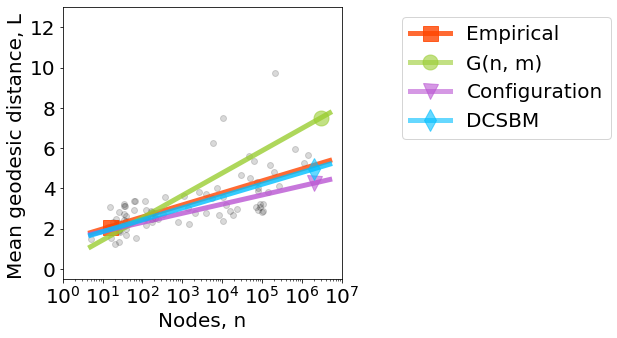

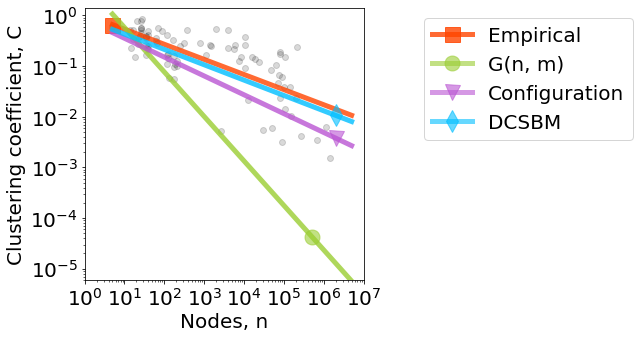

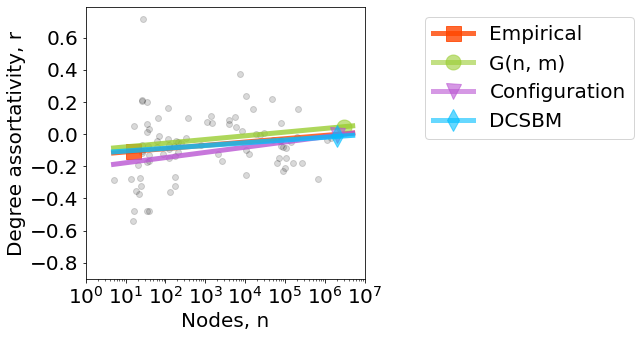

Biological


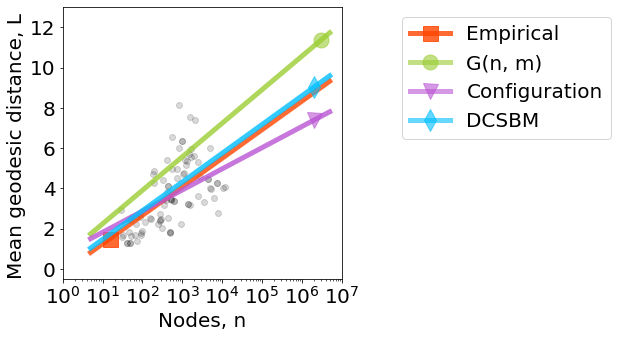

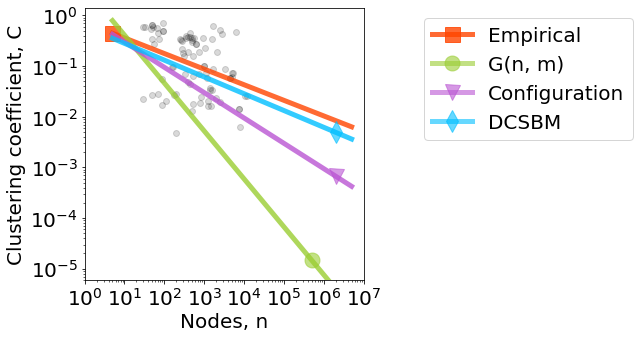

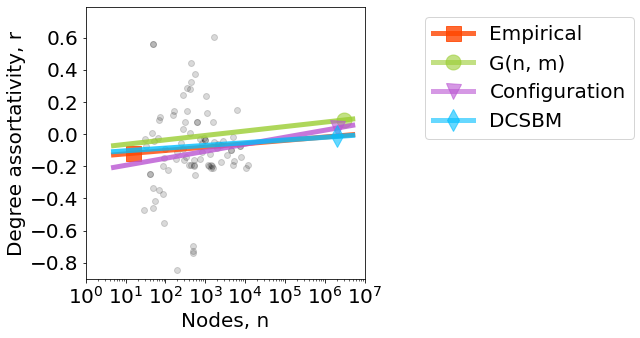

Informational


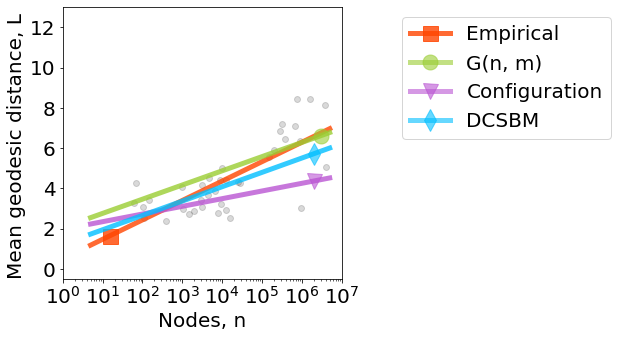

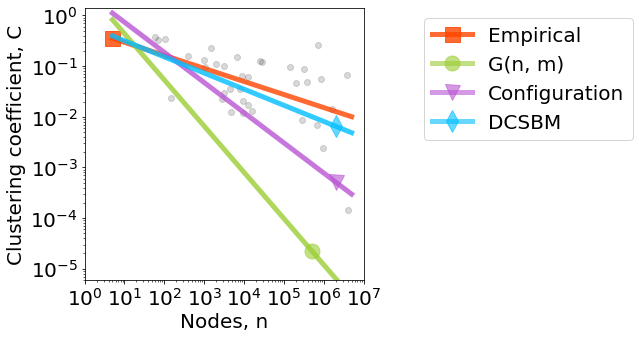

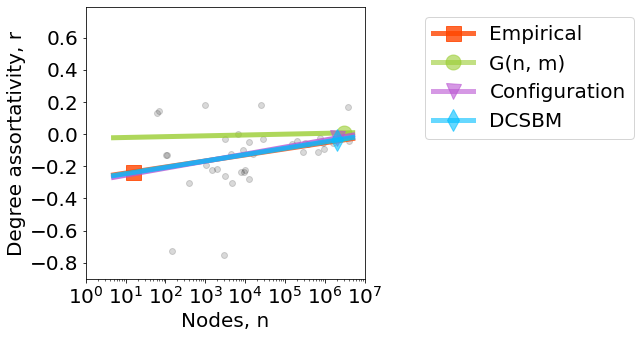

Technological


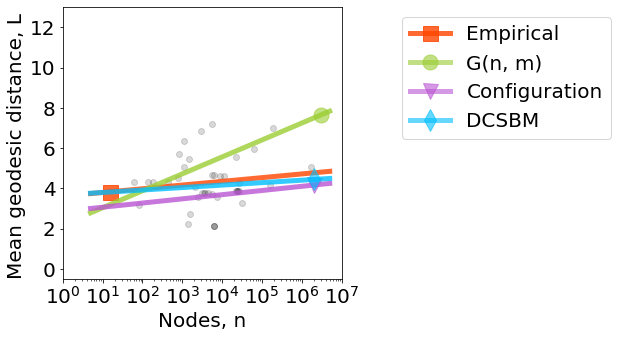

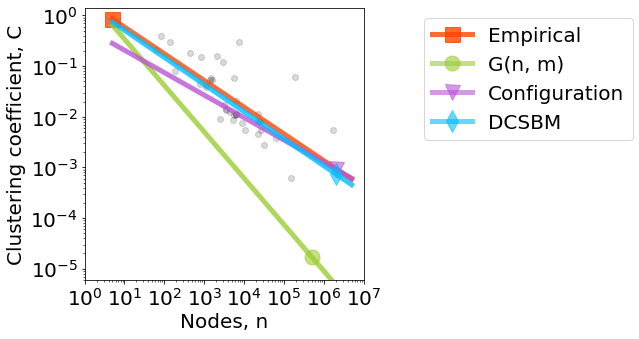

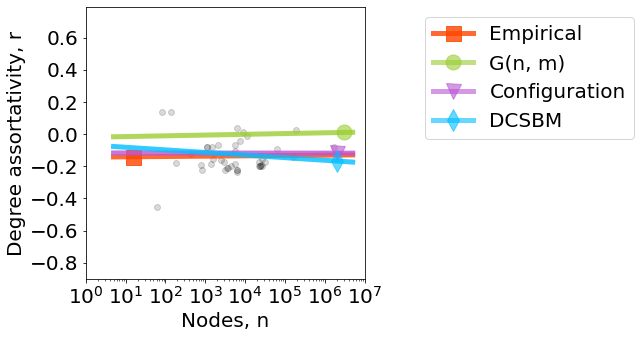

In [7]:
for chosenDomain in ["Social", "Biological", "Informational", "Technological"]:
    print(chosenDomain)
    for statistic in ["mgd", "cc", "r"]:
        plot_model_fits(chosenDomain, statistic)